<a href="https://www.kaggle.com/code/elcaiseri/icr-multiheads-ensemble-baseline-cv-0-23-eda?scriptVersionId=139624561" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

Update:
In version 1: i have started with classic classifer with Multi-Head trick. but results in the LB was too bad comparing by other notebooks. So I take it personally. In this version and next we would try as harder as we can to improve the CV.

What is New:
- scale the train data before training.
- no boost preds.
- use modified balance log loss.
- use oof as loss tracker **[CV 0.23]**.

## Imports

In [1]:
import numpy as np
import pandas as pd

import random

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt 

from tqdm.auto import tqdm

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import StratifiedGroupKFold, KFold

from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import roc_curve, auc

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

## Data Exploration

In [2]:
MAIN_DIR = "/kaggle/input/icr-identify-age-related-conditions/"

train = pd.read_csv(MAIN_DIR + "train.csv")
test = pd.read_csv(MAIN_DIR + "test.csv")
sub = pd.read_csv(MAIN_DIR + "sample_submission.csv")
greeks = pd.read_csv(MAIN_DIR + "greeks.csv")

In [3]:
train.head()

,Id,AB,AF,AH,AM,AR,AX,AY,AZ,BC,...,FL,FR,FS,GB,GE,GF,GH,GI,GL,Class
0,000ff2bfdfe9,0.209377,3109.03329,85.200147,22.394407,8.138688,0.699861,0.025578,9.812214,5.555634,...,7.298162,1.73855,0.094822,11.339138,72.611063,2003.810319,22.136229,69.834944,0.120343,1
1,007255e47698,0.145282,978.76416,85.200147,36.968889,8.138688,3.632190,0.025578,13.517790,1.229900,...,0.173229,0.49706,0.568932,9.292698,72.611063,27981.562750,29.135430,32.131996,21.978000,0
2,013f2bd269f5,0.470030,2635.10654,85.200147,32.360553,8.138688,6.732840,0.025578,12.824570,1.229900,...,7.709560,0.97556,1.198821,37.077772,88.609437,13676.957810,28.022851,35.192676,0.196941,0
3,043ac50845d5,0.252107,3819.65177,120.201618,77.112203,8.138688,3.685344,0.025578,11.053708,1.229900,...,6.122162,0.49706,0.284466,18.529584,82.416803,2094.262452,39.948656,90.493248,0.155829,0
4,044fb8a146ec,0.380297,3733.04844,85.200147,14.103738,8.138688,3.942255,0.054810,3.396778,102.151980,...,8.153058,48.50134,0.121914,16.408728,146.109943,8524.370502,45.381316,36.262628,0.096614,1


In [4]:
greeks.head()

,Id,Alpha,Beta,Gamma,Delta,Epsilon
0,000ff2bfdfe9,B,C,G,D,3/19/2019
1,007255e47698,A,C,M,B,Unknown
2,013f2bd269f5,A,C,M,B,Unknown
3,043ac50845d5,A,C,M,B,Unknown
4,044fb8a146ec,D,B,F,B,3/25/2020


In [5]:
train.shape, train.Class.value_counts()

((617, 58),
 0    509
 1    108
 Name: Class, dtype: int64)

target is unbalanced

In [6]:
train.isna().sum()

Id        0
AB        0
AF        0
AH        0
AM        0
AR        0
AX        0
AY        0
AZ        0
BC        0
BD        0
BN        0
BP        0
BQ       60
BR        0
BZ        0
CB        2
CC        3
CD        0
CF        0
CH        0
CL        0
CR        0
CS        0
CU        0
CW        0
DA        0
DE        0
DF        0
DH        0
DI        0
DL        0
DN        0
DU        1
DV        0
DY        0
EB        0
EE        0
EG        0
EH        0
EJ        0
EL       60
EP        0
EU        0
FC        1
FD        0
FE        0
FI        0
FL        1
FR        0
FS        2
GB        0
GE        0
GF        0
GH        0
GI        0
GL        1
Class     0
dtype: int64

there are some missing values in the dataset, let's explore how do we can impute them

## Data Preproccessing

In [7]:
# define heads
heads = [
    ['AB', 'AF', 'AH', 'AM', 'AR', 'AX', 'AY', 'AZ'],
    ['BC', 'BD ', 'BN', 'BP', 'BQ', 'BR', 'BZ'], 
    ['CB', 'CC', 'CD ', 'CF', 'CH', 'CL', 'CR', 'CS', 'CU', 'CW '], 
    ['DA', 'DE', 'DF', 'DH', 'DI', 'DL', 'DN', 'DU', 'DV', 'DY'], 
    ['EB', 'EE', 'EG', 'EH', 'EJ', 'EL', 'EP', 'EU'], # EJ is categorical
    ['FC', 'FD ', 'FE', 'FI', 'FL', 'FR', 'FS'], 
    ['GB', 'GE', 'GF', 'GH', 'GI', 'GL'], 
]

n_heads = len(heads)

n_heads

7

In [8]:
cat_col = 'EJ'

train[cat_col] = train[cat_col].map({"A":0, "B":1})
test[cat_col] = test[cat_col].map({"A":0, "B":1})

In [9]:
drop_cols = ["Id", "EJ", "Class"]

feat_cols = [col for col in train.columns if col not in drop_cols]

In [10]:
target_col =  'Class'
labels = train[target_col].values

## Data Visualization

In [11]:
b_df = train[heads[1]]

b_df.describe()

,BC,BD,BN,BP,BQ,BR,BZ
count,617.000000,617.000000,617.000000,617.000000,557.000000,617.000000,617.000000
mean,8.053012,5350.388655,21.419492,231.322223,98.328737,1218.133238,550.632525
std,65.166943,3021.326641,3.478278,183.992505,96.479371,7575.293707,2076.371275
min,1.229900,1693.624320,9.886800,72.948951,1.331155,51.216883,257.432377
25%,1.229900,4155.702870,19.420500,156.847239,27.834425,424.990642,257.432377
50%,1.229900,4997.960730,21.186000,193.908816,61.642115,627.417402,257.432377
75%,5.081244,6035.885700,23.657700,247.803462,134.009015,975.649259,257.432377
max,1463.693448,53060.599240,29.307300,2447.810550,344.644105,179250.252900,50092.459300


In most featuers/cases maximum values are far away from the closest quintile, in this case median is preferred over mean in order to describe the features distributions.

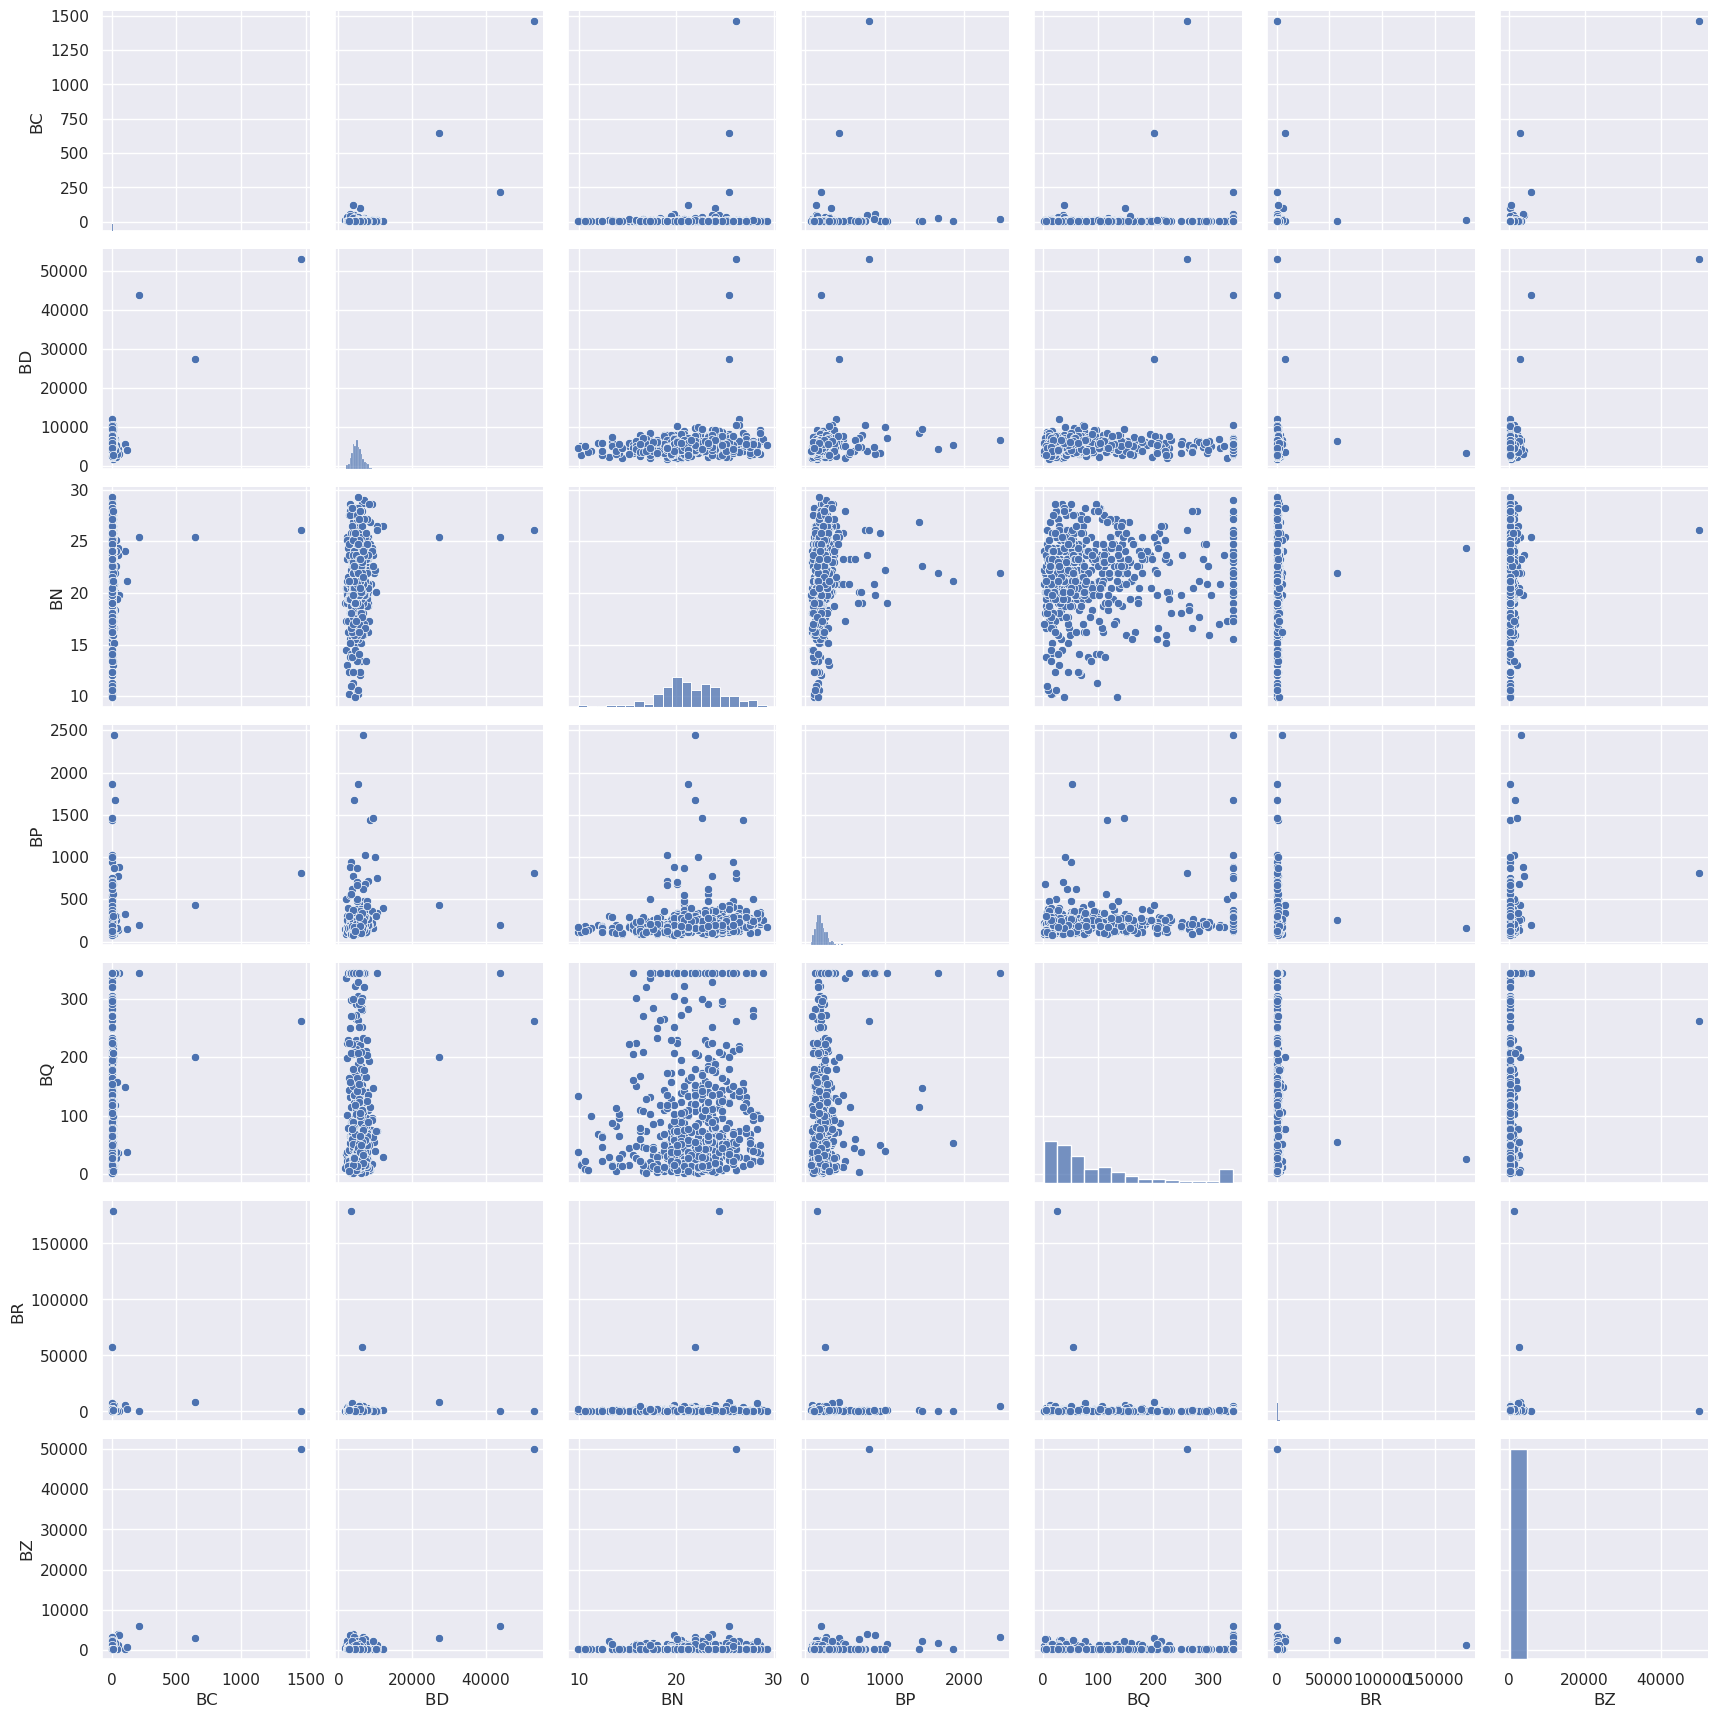

In [12]:
sns.pairplot(b_df, );

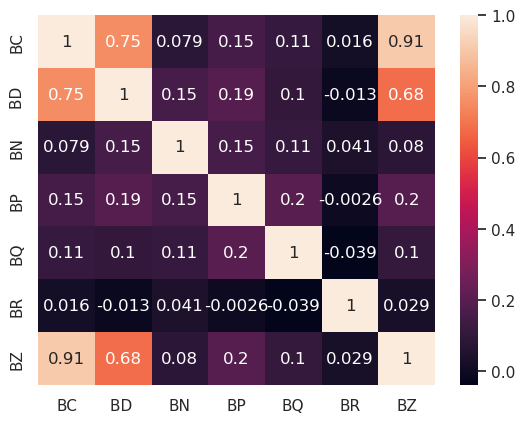

In [13]:
sns.heatmap(b_df.corr(), annot=True);

there are some linear correlation between heads and itself.

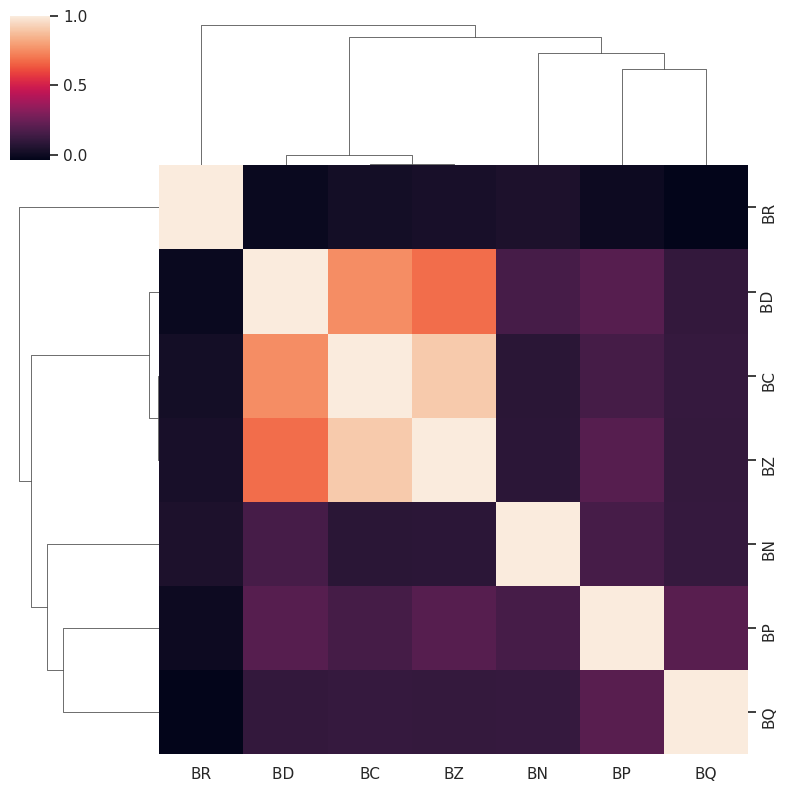

In [14]:
sns.clustermap(b_df.corr(), metric="correlation", figsize=(8, 8));

## Model

The idea behined MultiHeads is simple, we would use No. of heads as features to predict class/target and ensamble all predictions over multi models (linear, tree and ensemble, etc)

### Metrics

In [15]:
# define loss
def balanced_log_loss(y_true, y_pred):
    # y_true: correct labels 0, 1
    # y_pred: predicted probabilities of class=1
    # calculate the number of observations for each class
    N_0 = np.sum(1 - y_true)
    N_1 = np.sum(y_true)
    # calculate the weights for each class to balance classes
    w_0 = 1 / N_0
    w_1 = 1 / N_1
    # calculate the predicted probabilities for each class
    p_1 = np.clip(y_pred, 1e-15, 1 - 1e-15)
    p_0 = 1 - p_1
    # calculate the summed log loss for each class
    log_loss_0 = -np.sum((1 - y_true) * np.log(p_0))
    log_loss_1 = -np.sum(y_true * np.log(p_1))
    # calculate the weighted summed logarithmic loss
    # (factgor of 2 included to give same result as LL with balanced input)
    balanced_log_loss = 2*(w_0 * log_loss_0 + w_1 * log_loss_1) / (w_0 + w_1)
    # return the average log loss
    return balanced_log_loss/(N_0+N_1)

# https://www.kaggle.com/code/datafan07/icr-simple-eda-baseline
def balance_logloss(y_true, y_pred):
    
    y_pred = np.stack([1-y_pred,y_pred]).T
    y_pred = np.clip(y_pred, 1e-15, 1-1e-15)
    y_pred / np.sum(y_pred, axis=1)[:, None]
    nc = np.bincount(y_true)
    
    logloss = (-1/nc[0]*(np.sum(np.where(y_true==0,1,0) * np.log(y_pred[:,0]))) - 1/nc[1]*(np.sum(np.where(y_true!=0,1,0) * np.log(y_pred[:,1])))) / 2
    
    return logloss

# balanced preds
def boost_preds(yp):
    c_0, c_1 = yp.sum(axis=0)
    # Weighted probabilities based on class imbalance
    prob = yp * np.array([[1/(c_0 if i==0 else c_1) for i in range(yp.shape[1])]])
    yp_ = prob / np.sum(prob, axis=1, keepdims=1)
    
    return yp_

# https://www.kaggle.com/competitions/icr-identify-age-related-conditions/discussion/412507#2291644
def more_boost(oof, c):
    return c*oof / (1 - oof + c*oof)

### Impute

In [16]:
all_cols = feat_cols + [cat_col]
imputer = SimpleImputer(strategy="median")
imputer.fit(train[all_cols])

train[all_cols] = imputer.transform(train[all_cols])
test[all_cols] = imputer.transform(test[all_cols])

### Normailization

In [17]:
# default range (0, 1) but the original range is very large, so i descide to scale it larger range
sc = MinMaxScaler(feature_range=(-1, 1)) 
sc.fit(train[all_cols])

train[all_cols] = sc.transform(train[all_cols])
test[all_cols] = sc.transform(test[all_cols])

### Classifiers

In [18]:
lr = LogisticRegression(C=5.006, 
                        #class_weight="balanced", 
                        random_state=666, 
                        max_iter=600
                       )

svm = SVC(C=5.005, 
          #class_weight="balanced", 
          probability=True
         )

rfc = RandomForestClassifier(n_estimators=600, 
                             max_depth=8, 
                             random_state=666, 
                             class_weight="balanced", 
                             criterion="log_loss", 
                             max_features=0.6
                            )

cat = CatBoostClassifier(iterations=100, 
                         learning_rate=0.05, 
                         random_seed=666, 
                         verbose=0, 
                         #auto_class_weights='Balanced'
                        )

xgb = XGBClassifier(base_score=0.5, 
                    booster='gbtree', 
                    learning_rate=0.300000012, 
                    max_depth=6, 
                    n_estimators=100, 
                    verbosity=None, 
                    objective="binary:logistic",
                   )

xgb1 = XGBClassifier(n_estimators=100, 
                     max_depth=3, 
                     learning_rate=0.2, 
                     subsample=0.9, 
                     colsample_bytree=0.85
                    )

clfs = [svm, xgb, xgb1, xgb1, xgb1]

### Training

In [19]:
heads_ = heads + [all_cols] * 13 # len(heads_) == 20
n_splits = 11 

loss = []
result = np.zeros(len(test))

count = 0
oof = np.zeros(len(train))
for rs, head in enumerate(tqdm(heads_, total=len(heads_))):
    head = all_cols ## use all feats. as head every iter.
    print("HEAD", rs) #, head)
    train_df = train[head].values
    test_df = test[head].values
    
    gkf = KFold(n_splits=n_splits, shuffle=True, random_state=rs*rs)
    ids = gkf.split(train_df, labels, groups=greeks.iloc[:, 1:-1].sum(1))

    head_result = []
    head_loss = []
    for idx, (train_idx, val_idx) in enumerate(ids): 
        # select fold
        print("--> FOLD:", idx+1, end=" | ") 
        xr, xt = train_df[train_idx], train_df[val_idx] 
        yr, yt = labels[train_idx], labels[val_idx]
        
        # under sampleing
        NUM_POS = np.bincount(yr)[1]
        sampler = RandomUnderSampler(sampling_strategy={0: int(NUM_POS*1.3), 1: NUM_POS}, random_state=rs*idx)
        xr_, yr = sampler.fit_resample(xr, yr)
        
        # train
        for clf in clfs:
            clf.fit(xr_, yr)
            
            yp = clf.predict_proba(xt)
            oof[val_idx] += yp[:, 1] / len(heads_) / len(clfs)
            count += 1
            
            # test
            result += clf.predict_proba(test_df)[:, 1] / len(heads_) / len(clfs)
            
            # tracking loss
            log_loss = balance_logloss(yt, yp[:, 1]) # 
            loss.append(log_loss)
            
            fpr, tpr, thresholds = roc_curve(yt, yp[:, 1])
            auc_score = auc(fpr, tpr)
            
    print("="*12)
        
    #break

  0%|          | 0/20 [00:00<?, ?it/s]

HEAD 0
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | --> FOLD: 6 | --> FOLD: 7 | --> FOLD: 8 | --> FOLD: 9 | --> FOLD: 10 | --> FOLD: 11 | ============
HEAD 1
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | --> FOLD: 6 | --> FOLD: 7 | --> FOLD: 8 | --> FOLD: 9 | --> FOLD: 10 | --> FOLD: 11 | ============
HEAD 2
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | --> FOLD: 6 | --> FOLD: 7 | --> FOLD: 8 | --> FOLD: 9 | --> FOLD: 10 | --> FOLD: 11 | ============
HEAD 3
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | --> FOLD: 6 | --> FOLD: 7 | --> FOLD: 8 | --> FOLD: 9 | --> FOLD: 10 | --> FOLD: 11 | ============
HEAD 4
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | --> FOLD: 6 | --> FOLD: 7 | --> FOLD: 8 | --> FOLD: 9 | --> FOLD: 10 | --> FOLD: 11 | ============
HEAD 5
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | --> FOLD: 6 | --> FOLD: 7 | --> FOLD: 8 | -

Now training logs looks better.

## Evaluate

In [20]:
overall_cv = balance_logloss(labels, oof)

overall_cv

0.23767684650081183

In [21]:
np.min(loss), np.mean(loss)

(0.05830854756859652, 0.29718033395562676)

In [22]:
bst_cv = np.inf
bst_c = 0

for b in range(1, 50):
    oof_ = more_boost(oof, b)
    cv_loss = balanced_log_loss(train.Class.values, oof_)
    if cv_loss < bst_cv:
        print(b, "=>",cv_loss)
        bst_cv = cv_loss
        bst_c = b

1 => 0.13728341618321127


Watch out! good people, we overfitting.

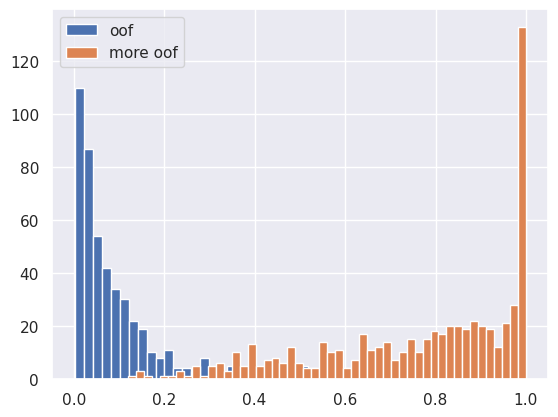

In [23]:
plt.hist(oof, bins=50, label="oof");
plt.hist(oof_, bins=50, label="more oof");
plt.legend()
plt.show()

In [24]:
test_pred_1 = result/n_splits #more_boost(result/n_splits, bst_c)
test_pred_0 = 1 - test_pred_1

test_pred_1, test_pred_0

(array([0.41031283, 0.41031283, 0.41031283, 0.41031283, 0.41031283]),
 array([0.58968717, 0.58968717, 0.58968717, 0.58968717, 0.58968717]))

## Submission

In [25]:
preds_cols = ["class_0", "class_1"]
sub[preds_cols] = np.array([test_pred_0, test_pred_1]).T
sub.to_csv("submission.csv", index=False)

sub

,Id,class_0,class_1
0,00eed32682bb,0.589687,0.410313
1,010ebe33f668,0.589687,0.410313
2,02fa521e1838,0.589687,0.410313
3,040e15f562a2,0.589687,0.410313
4,046e85c7cc7f,0.589687,0.410313


This is a baseline, if you have any farther recommandetions, write it in the comment section.

**Upvote** if you like it, your feedback is highly appreciated

In [26]:
oof1 = oof

In [27]:
import keras.backend as K

def keras_balance_logloss(y_true, y_pred):
    y_pred = K.stack([1 - y_pred, y_pred], axis=1)
    y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
    y_pred /= K.sum(y_pred, axis=1, keepdims=True)
    nc = K.sum(K.cast(K.equal(y_true, 0), dtype=K.floatx()))

    logloss = (-1 / nc * K.sum(K.cast(K.equal(y_true, 0), dtype=K.floatx()) * K.log(y_pred[:, 0])) -
               (1 - 1 / nc) * K.sum(K.cast(K.not_equal(y_true, 0), dtype=K.floatx()) * K.log(y_pred[:, 1]))) / 2

    return logloss

# Example usage:
y_true = np.array([0, 1, 0, 1, 0])
y_pred = np.array([0.3, 0.7, 0.6, 0.4, 0.9])

loss = keras_balance_logloss(K.variable(y_true), K.variable(y_pred))
print(K.eval(loss))


/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

1.020247


In [28]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential


def model(hidden_sizes=[128, 128, 64]):
    model = Sequential()
    model.add(layers.Dense(hidden_sizes[0], activation='relu', input_shape=(len(all_cols),)))
    
    for size in hidden_sizes[1:]:
        model.add(layers.Dense(size, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    # Compile the model
    opt = keras.optimizers.Adam(lr=0.2)
    model.compile(optimizer=opt, loss=keras_balance_logloss)
    
    return model

In [29]:
model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               7296      
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 32,129
Trainable params: 32,129
Non-trainable params: 0
_________________________________________________________________


In [30]:
heads_ = heads + [all_cols] * 3 # len(heads_) == 10
n_splits = 5 

loss = []
result = np.zeros(len(test))

count = 0
oof = np.zeros(len(train))
for rs, head in enumerate(tqdm(heads_, total=len(heads_))):
    head = all_cols ## use all feats. as head every iter.
    print("HEAD", rs) #, head)
    train_df = train[head].values
    test_df = test[head].values
    
    gkf = KFold(n_splits=n_splits, shuffle=True, random_state=rs)
    ids = gkf.split(train_df, labels, groups=greeks.iloc[:, 1:-1].sum(1))

    head_result = []
    head_loss = []
    clfs = [model([128, 64, 64]), model([64, 32, 32])]
    for idx, (train_idx, val_idx) in enumerate(ids): 
        # select fold
        print("--> FOLD:", idx+1, end=" | ") 
        xr, xt = train_df[train_idx], train_df[val_idx] 
        yr, yt = labels[train_idx], labels[val_idx]
        
        # under sampleing
        NUM_POS = np.bincount(yr)[1] # {0: int(NUM_POS*1.3), 1: NUM_POS}
        sampler = RandomOverSampler(sampling_strategy="auto", random_state=rs*idx)
        xr_, yr = sampler.fit_resample(xr, yr)
        
        # train
        for clf in clfs:
            #clf.fit(xr_, yr)
            # Train the model
            clf.fit(xr_, yr, epochs=100, batch_size=64, validation_data=(xt, yt), shuffle=True, verbose=0)
            
            yp = clf.predict(xt, verbose=0)
            oof[val_idx] += yp[:, 0] / len(heads_) / len(clfs)
            count += 1
            
            # test
            result += clf.predict(test_df, verbose=0)[:, 0] / len(heads_) / len(clfs)
            
    # tracking loss
    log_loss = balance_logloss(labels, oof) # 
    loss.append(log_loss)
    print("logLoss:", log_loss)

    #fpr, tpr, thresholds = roc_curve(yt, yp[:, 0])
    #auc_score = auc(fpr, tpr)
            
    print("="*12)
        
    #break

  0%|          | 0/10 [00:00<?, ?it/s]

HEAD 0
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | ============
HEAD 1
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | ============
HEAD 2
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | ============
HEAD 3
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | ============
HEAD 4
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | ============
HEAD 5
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | ============
HEAD 6
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | ============
HEAD 7
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | ============
HEAD 8
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | ============
HEAD 9
--> FOLD: 1 | --> FOLD: 2 | --> FOLD: 3 | --> FOLD: 4 | --> FOLD: 5 | ============


In [75]:
balance_logloss(labels, more_boost(boost_preds(np.array([1-oof, oof1]).T)[:, 1], 1)), balance_logloss(labels, oof)

(0.22703834512507332, 0.26263405262181694)

In [71]:
balance_logloss(labels, more_boost(oof1, 1)), balance_logloss(labels, oof1), 

(0.23767684650081183, 0.23767684650081183)

In [65]:
balance_logloss(labels, (boost_preds(np.array([1-oof, oof1]).T)[:, 1] + oof + oof1)/3)

0.21882898720393545

In [60]:
balance_logloss(labels, boost_preds(np.array([1-oof1, oof]).T)[:, 1]), balance_logloss(labels, oof)

(0.31993994790282954, 0.26263405262181694)

In [55]:
balance_logloss(labels, boost_preds(np.array([1-oof1, oof1]).T)[:, 1]), balance_logloss(labels, oof1)

(0.2673222579597391, 0.23767684650081183)

In [52]:
boost_preds(np.array([1-oof, oof]).T)[:, 1]

array([0.99777592, 0.43323524, 0.57720057, 0.26406625, 0.99144144,
       0.43311011, 0.43959116, 0.35212922, 0.26410405, 0.38090813,
       0.9080709 , 0.32134916, 0.53936169, 0.99986243, 0.31382693,
       0.95660189, 0.43469401, 0.26825266, 0.9692266 , 0.53722852,
       0.37841799, 0.53613937, 0.26185131, 0.37355628, 0.37815047,
       0.38429628, 0.32109556, 0.32111824, 0.34012926, 0.58192791,
       0.28907585, 0.99556541, 0.88490185, 0.43310842, 0.33355427,
       0.48610228, 0.99403053, 0.13626985, 0.32110273, 0.43321277,
       0.34570042, 0.99160474, 0.491796  , 0.2619477 , 0.37831499,
       0.36234551, 0.3211769 , 0.43321538, 0.38426956, 0.84522687,
       0.35739221, 0.58713619, 0.16133014, 0.15680252, 0.36862065,
       0.30596276, 0.2939161 , 0.3781825 , 0.60837501, 0.22353474,
       0.26200743, 0.40636587, 0.28754767, 0.32110909, 0.37824325,
       0.20620782, 0.63689229, 0.39042298, 0.34280049, 0.20716085,
       0.38560391, 0.26346978, 0.48254943, 0.26380269, 0.37199

In [51]:
oof

array([0.99684726, 0.35011755, 0.4903594 , 0.20184558, 0.98789991,
       0.3500016 , 0.35602005, 0.27696788, 0.20187691, 0.30247188,
       0.87440111, 0.25022032, 0.45212565, 0.99980482, 0.24376504,
       0.93952318, 0.35147   , 0.20532077, 0.95689228, 0.45000044,
       0.30024582, 0.4489166 , 0.20001069, 0.29591031, 0.30000689,
       0.30550663, 0.25000218, 0.25002169, 0.26647576, 0.49520855,
       0.22274589, 0.99371957, 0.84420212, 0.35000003, 0.26076192,
       0.4000002 , 0.99155124, 0.10006682, 0.25000834, 0.35009673,
       0.27133659, 0.98812997, 0.40548116, 0.20009049, 0.30015382,
       0.28596604, 0.25007214, 0.35009914, 0.30548267, 0.79376737,
       0.28159576, 0.50056999, 0.11938958, 0.11587636, 0.29152316,
       0.23705002, 0.22682988, 0.3000355 , 0.52264142, 0.16867541,
       0.20013994, 0.32544311, 0.22145913, 0.25001381, 0.30008975,
       0.1547533 , 0.55281276, 0.31101171, 0.26880419, 0.15551512,
       0.30667971, 0.2013512 , 0.396591  , 0.20162711, 0.29452

In [45]:
balance_logloss(labels, (.15*oof + .85*oof1))

0.22455833549825563

In [37]:
(oof1 - oof).mean()

-0.15519853637277142

In [40]:
1-.15

0.85